In [1]:
import os
import cv2
import numpy as np
from os import listdir
from PIL import Image
from os.path import isfile, join
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
img_rows, img_col = 224,224
# Re-loads the MobileNet model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_col, 3))
#here we freeze the last 4 layers
#layers are set trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False

for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

def lw(bottom_model, num_classes):
  top_model = bottom_model.output
# GlobalAveragePooling2D:
# Tóm tắt toàn bộ thông tin không gian (height và width) của đầu ra từ bottom_model thành một vector duy nhất.
# Hiệu quả hơn so với Flatten() vì nó giảm số lượng tham số cần học, tránh hiện tượng overfitting.
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation ='relu')(top_model)
  top_model = Dense(1024, activation ='relu')(top_model)
  top_model = Dense(512, activation ='relu')(top_model)
#Hàm kích hoạt softmax được sử dụng để chuyển đổi đầu ra thành xác suất, mỗi xác suất đại diện cho một lớp.
  top_model = Dense(num_classes, activation = 'softmax')(top_model)
  return top_model

num_classes = 5
FC_Head = lw(vgg16, num_classes)
model = Model(inputs = vgg16.input, outputs = FC_Head)
print(model.summary())

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,816,965 (64.15 MB)

 Trainable params: 2,102,277 (8.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [4]:
train_data_dir = "D:/DangTranTanLuc/Data/Train"
validation_data_dir = "D:/DangTranTanLuc/Data/Validate"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_batchsize = 15
val_batchsize = 5
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_rows, img_col),
    batch_size = train_batchsize,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_rows, img_col),
    batch_size = val_batchsize,
    class_mode = 'categorical'
)
label_map = train_generator.class_indices
label_map = {v: k for k, v in label_map.items()}

print("Label Map:", label_map)

Found 75 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Label Map: {0: 'Dang Tran Tan Luc', 1: 'Nguyen Thi Ngoc Diem', 2: 'Phung Khanh Duy', 3: 'Vo Nguyen Thanh Dieu', 4: 'Vo Thi Cam Tu'}


In [6]:
check_point = ModelCheckpoint('facerecognition.keras', monitor = 'val_loss', mode='min',
                              save_best_only = True, verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)
callbacks = [early_stop, check_point, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(learning_rate = 0.001), metrics = ['accuracy'])

nb_train_samples = 225
nb_validation_samples = 25
print("Classes in train_generator:", train_generator.num_classes)
print("Classes in validation_generator:", validation_generator.num_classes)

epochs = 25
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples//batch_size
)

Classes in train_generator: 5
Classes in validation_generator: 5
Epoch 1/25
5/7 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2633 - loss: 1.6308
Epoch 1: val_loss improved from inf to 1.22260, saving model to facerecognition.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2643 - loss: 1.6328 - val_accuracy: 0.3600 - val_loss: 1.2226 - learning_rate: 0.0010
Epoch 2/25
5/7 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4476 - loss: 1.3383
Epoch 2: val_loss improved from 1.22260 to 1.08890, saving model to facerecognition.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4416 - loss: 1.3479 - val_accuracy: 0.4000 - val_loss: 1.0889 - learning_rate: 0.0010
Epoch 3/25
5/7 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4558 - loss: 1.2372
Epoch 3: val_loss did not improve from 1.08890
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4322 - loss: 1.2901 - val_accuracy: 0.2800 - val_loss: 1.4087 - learning_rate: 0.0010
Epoch 4/25
5/7 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy:

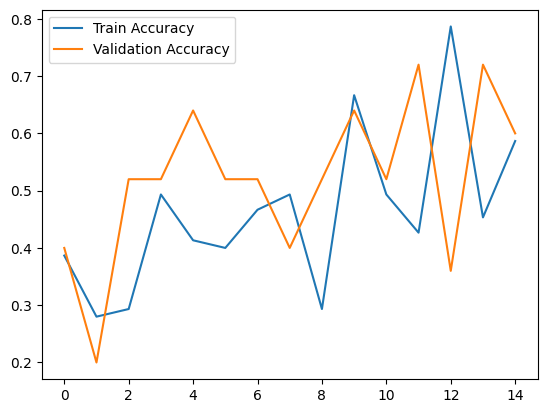

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [14]:
classifier = load_model("D:/DangTranTanLuc/Python/ProjectPy/FaceRecognitionSystem/facerecognition.keras")


def draw_test(name, pred, im):
    face = label_map[pred[0]]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, face, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 1)
    cv2.imshow("Prediction", expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + path_class)
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)

for i in range(0,10):
    input_im = getRandomImage("D:/DangTranTanLuc/Data/Validate/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)

    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3)

    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)

    draw_test("Prediction", res, input_original)
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - Phung Khanh Duy
Class - Dang Tran Tan Luc
Class - Vo Thi Cam Tu
Class - Vo Nguyen Thanh Dieu
Class - Phung Khanh Duy
Class - Vo Nguyen Thanh Dieu
Class - Nguyen Thi Ngoc Diem
Class - Phung Khanh Duy
Class - Vo Nguyen Thanh Dieu
Class - Vo Nguyen Thanh Dieu


In [16]:
classifier = load_model("D:/DangTranTanLuc/Python/ProjectPy/FaceRecognitionSystem/facerecognition.keras")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [22]:
label_map = {0: 'Dang Tran Tan Luc', 1: 'Nguyen Thi Ngoc Diem', 2: 'Phung Khanh Duy', 3: 'Vo Nguyen Thanh Dieu', 4: 'Vo Thi Cam Tu'}

def face_extractor(img):
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return None
    
    # Crop all faces found
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

# Doing some Face Recognition with the webcam
video_capture = cv2.VideoCapture(0)

while True:
    _, frame = video_capture.read()
    
    face = face_extractor(frame)
    if face is not None:
        face = cv2.resize(face, (224, 224))
        im = Image.fromarray(face, 'RGB')
        img_array = np.array(im)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make prediction
        pred = classifier.predict(img_array)
        predicted_class = np.argmax(pred, axis=1)
        name = label_map[predicted_class[0]]

        # Display the name on the frame
        cv2.putText(frame, name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(frame, "No face detected", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Video', frame)

    # Exit the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

<>:6: SyntaxWarning: "is" with 'tuple' literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with 'tuple' literal. Did you mean "=="?
C:\Users\dttan\AppData\Local\Temp\ipykernel_7232\1996457940.py:6: SyntaxWarning: "is" with 'tuple' literal. Did you mean "=="?
  if faces is ():


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 